In [18]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")


In [11]:

df1 = pd.read_csv('C:/Users/Varun/Anaconda2/netflix-prize-data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [14]:
#df2 = pd.read_csv('C:/Users/Varun/Anaconda2/netflix-prize-data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('C:/Users/Varun/Anaconda2/netflix-prize-datat/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('C:/Users/Varun/Anaconda2/netflix-prize-data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


#df2['Rating'] = df2['Rating'].astype(float)
#df3['Rating'] = df3['Rating'].astype(float)
#df4['Rating'] = df4['Rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

In [15]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


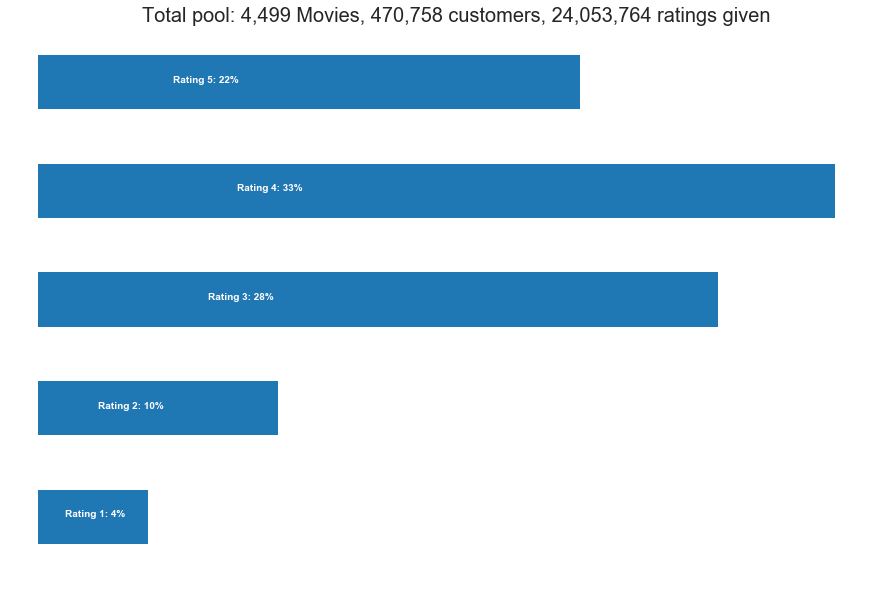

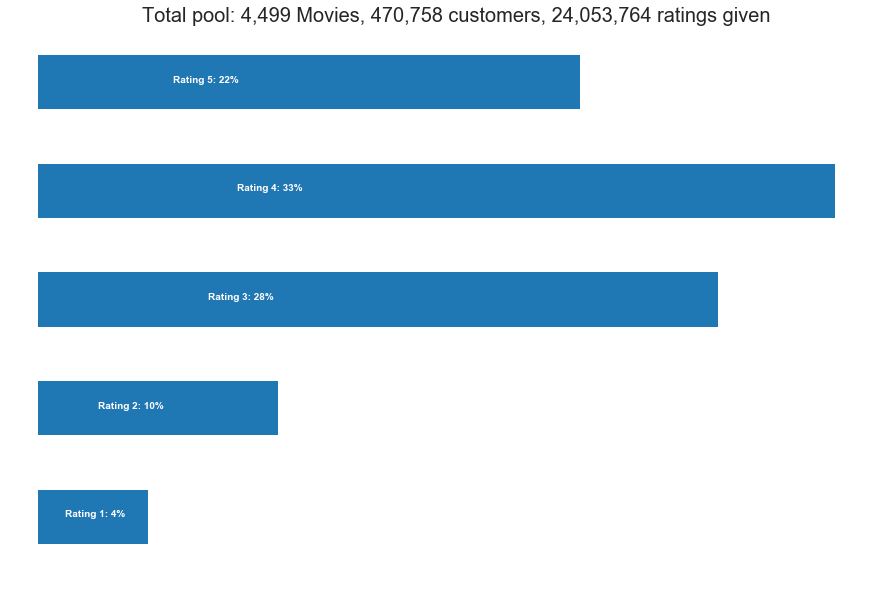

In [19]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [20]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   4.49900000e+03
   4.49900000e+03   4.49900000e+03]
Length: 24053764


In [21]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

C:\Users\Varun\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


C:\Users\Varun\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [22]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))


Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0


In [23]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (13528427, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
5109       785314     1.0         8
8889698    332300     3.0      1770
17751978   629874     4.0      3391


In [24]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)

(95325, 900)


In [26]:
df_title = pd.read_csv('C:/Users/Varun/Anaconda2/netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter
